In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

train_dir = '../../datasets/dataset2/train'
test_dir = '../../datasets/dataset2/test'
batch_size = 16
img_height, img_width = 64, 64
input_shape = (img_height, img_width, 3)


# Perform the train-validation split
train_images, validation_images, train_labels, validation_labels = train_test_split(
    os.listdir(train_dir),
    os.listdir(train_dir),
    test_size=0.2,
    random_state=42
)

# Define the data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255) # rescale the pixel values between 0 and 1
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # path to the training dataset
        target_size=(img_height, img_width), # resize images to this size
        batch_size=batch_size,
        class_mode='categorical') # output class labels as one-hot vectors

# Set up the validation data generator
validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
        test_dir,  # path to the testing dataset
        target_size=(img_height, img_width),
        batch_size=1, # batch size of 1 to test one image at a time
        class_mode='categorical')

# Check the mapping of labels to class indices
print(train_generator.class_indices)


Found 899 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}


In [28]:
# Create the CNN model
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Calculate the steps per epoch and validation steps
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

# Train the model

history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

# Plot the loss curves for training and validation datasets
plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['validation_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves for training and validation datasets
plt.plot(history.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['validation_loss'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Save the model
model.save('weather_classification_without_preprocessing.h5')


Epoch 1/10
56/56 [==============================] - 8s 125ms/step - loss: 0.9955 - accuracy: 0.5878
Epoch 2/10
56/56 [==============================] - 7s 126ms/step - loss: 0.5329 - accuracy: 0.8007
Epoch 3/10
56/56 [==============================] - 7s 127ms/step - loss: 0.3817 - accuracy: 0.8618
Epoch 4/10
56/56 [==============================] - 7s 126ms/step - loss: 0.2825 - accuracy: 0.8947
Epoch 5/10
56/56 [==============================] - 7s 127ms/step - loss: 0.2450 - accuracy: 0.8981
Epoch 6/10
56/56 [==============================] - 7s 129ms/step - loss: 0.2221 - accuracy: 0.9230
Epoch 7/10
56/56 [==============================] - 7s 128ms/step - loss: 0.2297 - accuracy: 0.9241
Epoch 8/10
56/56 [==============================] - 7s 125ms/step - loss: 0.1880 - accuracy: 0.9388
Epoch 9/10
56/56 [==============================] - 7s 126ms/step - loss: 0.1465 - accuracy: 0.9456
Epoch 10/10
56/56 [==============================] - 7s 126ms/step - loss: 0.1335 - accuracy: 0.9524

ValueError: Asked to retrieve element 0, but the Sequence has length 0

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

224/224 [==============================] - 5s 19ms/step - loss: 0.1959 - accuracy: 0.9420
Test loss: 0.1958548128604889
Test accuracy: 0.9419642686843872


Test on different dataset

In [ ]:
# Set the path to the test dataset (dataset1)
test_dir = '../../datasets/dataset1/test'

# Create the test data generator
test_generator = test_datagen.flow_from_directory(
        test_dir,  
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print('Test loss:', loss)
print('Test accuracy:', accuracy)


Found 1123 images belonging to 4 classes.
1123/1123 [==============================] - 22s 19ms/step - loss: 0.0918 - accuracy: 0.9715
Test loss: 0.09183308482170105
Test accuracy: 0.9715049266815186


1/1 [==============================] - 0s 146ms/step
Predicted class: rainy


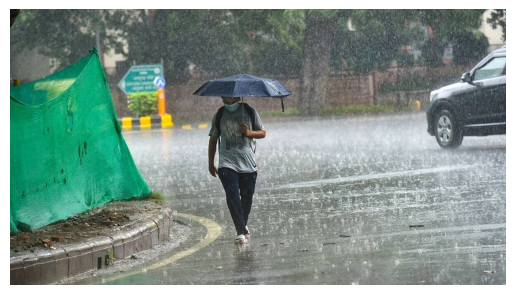

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = '../../paper/test_image.jpg'
img_height, img_width = 64, 64
# Load the test image
img = load_img(img_path, target_size=(img_height, img_width))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.

# Predict the class of the test image
preds = model.predict(x)
pred_class = np.argmax(preds, axis=1)[0]

# Print the predicted class and corresponding label
class_labels = {0: 'cloudy', 1: 'rainy', 2: 'shine', 3: 'sunrise'}
print('Predicted class:', class_labels[pred_class])

#read the image
image=mpimg.imread(img_path)
plt.axis('off')
plt.imshow(image)


1/1 [==============================] - 0s 39ms/step
Predicted class: shine


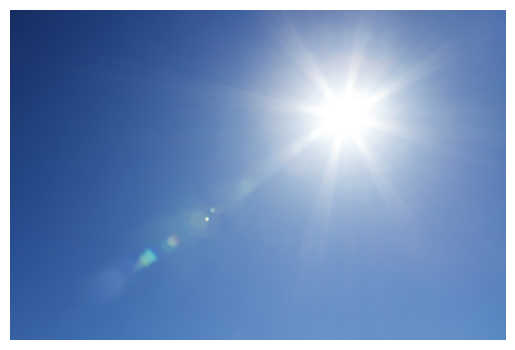

In [ ]:
img_path = '../../paper/test_image2.jpg'
img_height, img_width = 64, 64
# Load the test image
img = load_img(img_path, target_size=(img_height, img_width))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.

# Predict the class of the test image
preds = model.predict(x)
pred_class = np.argmax(preds, axis=1)[0]

print('Predicted class:', class_labels[pred_class])

#read the image
image=mpimg.imread(img_path)
plt.axis('off')
plt.imshow(image)


1/1 [==============================] - 0s 34ms/step
Predicted class: sunrise


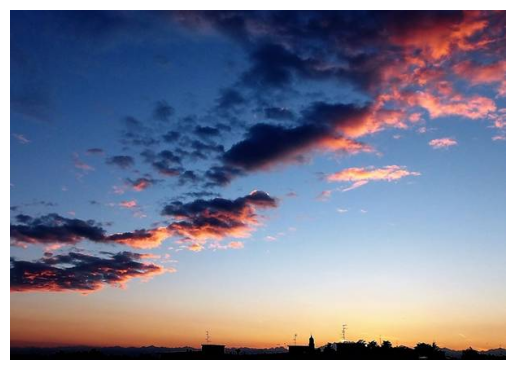

In [ ]:
img_path = '../../paper/test_image3.jpg'
img_height, img_width = 64, 64
# Load the test image
img = load_img(img_path, target_size=(img_height, img_width))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.

# Predict the class of the test image
preds = model.predict(x)
pred_class = np.argmax(preds, axis=1)[0]

print('Predicted class:', class_labels[pred_class])

#read the image
image=mpimg.imread(img_path)
plt.axis('off')
plt.imshow(image)

